# <span style="color:turquoise">**Detección de células redondas utilizando Yolo**</span>

## **Hardware**

In [1]:
!nvidia-smi

Sat Aug 30 12:10:51 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA TITAN Xp                Off | 00000000:84:00.0 Off |                  N/A |
| 23%   34C    P8              10W / 250W |      6MiB / 12288MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## **Introducción**

En este TFM se pretende realizar un estudio del arte y entrenamiento de diferentes modelos (YOLO, Fast-RCNN, propio) para la detección de células y artefactos en imágenes médicas. Para esto, se aplican técnicas de visión por computador y aprendizaje profundo. Además, se realizará un exahustiva revisión de la bibliografía existente, mejora del dataset y análisis estadistico fundamentado en las diferentes métricas.

## **Dependencias**

In [ ]:
# %pip install -U ipywidgets jupyter
# %pip install ultralytics
# !pip install optuna

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import json
import optuna
import shutil
import pandas as pd
import torch

from ultralytics import YOLO
from lib.YOLO_lib import config, optuna_utils, plot_utils, kfold_utils, evaluation

In [2]:
print(f"Versión de PyTorch + CUDA: {torch.__version__}")
print(f"Diponible CUDA: {torch.cuda.is_available()}. \nDispositivo CUDA: {torch.cuda.get_device_name(0)}")

Versión de PyTorch + CUDA: 2.6.0+cu124
Diponible CUDA: True. 
Dispositivo CUDA: NVIDIA TITAN Xp


## **Entrenamineto de los modelos YOLOv11 y YOLOv12**

### **Configuración**

Entrenamiento con modelos de YOLO con pesos de COCO

In [3]:
selected_model = "yolov12l"  # "custom" o "yolovXs"
model_dir = "yolo/yolo_models"
model_path = os.path.join(model_dir, f"{selected_model}.pt")
# model_path = os.path.join(model_dir, f"{selected_model}.yaml")

if selected_model not in config.models:
    if(selected_model == "custom"):
        model = YOLO(f"{selected_model}.yaml")
    else:
        model = YOLO(f"{selected_model}.pt")

    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    if not os.path.exists(model_path):
        if(selected_model == "custom"):
            shutil.move(f"{selected_model}.yaml", model_path)
        else:
            shutil.move(f"{selected_model}.pt", model_path)
else:
    model = YOLO(config.models[selected_model])

100%|██████████████████████████████████| 51.2M/51.2M [00:01<00:00, 37.4MB/s]


Recuerda que si hemos descargado un nuevo modelo, debemos añadirlo al archivod e configuración.

In [4]:
storage_name = f"sqlite:///optuna/optuna_studies/{selected_model}.db"
best_params_path = f"optuna/optuna_studies/{selected_model}_best_params.json"
image_optuna_path = f'optuna/optuna_plots/optimization_{selected_model}.png'
model_output = f"final_model_{selected_model}"
model_output_kfold = model_output + "_kfold"
name_best_params = f"best_params_{selected_model}"

### **Optuna**

In [5]:
study = optuna.create_study(
    direction="maximize",  # Maximizar mAP@0.5:0.95
    study_name=selected_model,
    storage=storage_name,
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(seed = config.SEED),  
    pruner=optuna.pruners.MedianPruner(n_startup_trials=3, n_warmup_steps=10)
)

study.optimize(lambda trial: optuna_utils.optuna_objective(trial, model, selected_model), n_trials=config.N_TRIALS, timeout=None)

print("Número de trials completados:", len(study.trials))

with open(best_params_path, 'w') as f:
    json.dump(study.best_trial.params, f, indent=2)

[I 2025-08-25 18:55:10,990] Using an existing study with name 'yolov12l' instead of creating a new one.


New https://pypi.org/project/ultralytics/8.3.185 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.169 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA TITAN Xp, 12190MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=0, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=cells.yaml, degrees=45, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=704, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0005611516415334506, lrf=0.00892718030435363, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo/yolo_models/yolo12l.pt, momentum=0.9097990912717108, mosaic=0, multi_scale=False, name=optun

train: Scanning /home/aitor/tfm/03.Datasets/YOLO_Datasets/split/train/labels

val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2090.1±749.5 MB/s, size: 89.7 KB)



val: Scanning /home/aitor/tfm/03.Datasets/YOLO_Datasets/split/val/labels.cac


Plotting labels to runs/detect/optuna_trial_yolov12l_2/labels.jpg... 
optimizer: SGD(lr=0.0005611516415334506, momentum=0.9097990912717108) with parameter groups 205 weight(decay=0.0), 214 weight(decay=0.00039687933304443713), 211 bias(decay=0.0)
Image sizes 704 train, 704 val
Using 0 dataloader workers
Logging results to runs/detect/optuna_trial_yolov12l_2
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      11.4G      2.718      4.667      1.482         50        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955     0.0132      0.311     0.0195    0.00751

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       2/25      11.4G      2.147      2.595      1.194          4        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.535       0.54       0.52      0.281

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       3/25      11.3G      1.778      1.497      1.071         28        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.668      0.694      0.684      0.267

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       4/25      11.3G      1.474      1.183     0.9566         25        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955       0.69      0.671      0.649      0.157

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       5/25      11.3G      1.317      1.603     0.9078          0        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.715      0.754      0.749      0.317

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       6/25      11.3G      1.226      1.059     0.9049          8        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.752      0.784      0.798      0.303

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       7/25      11.3G      1.184     0.9563     0.8829          8        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.758      0.799      0.829      0.388

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       8/25      11.3G      1.091     0.8767     0.8695          5        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.762      0.828      0.852       0.55

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       9/25      11.3G      1.096     0.8135     0.8692          4        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.792       0.81       0.86      0.546

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      10/25      11.3G      1.044     0.8025     0.8677         31        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.791      0.807       0.85      0.579

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      11/25      11.3G      1.021     0.7742     0.8599         42        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.806      0.795      0.859      0.591

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      12/25      11.3G     0.9744     0.7317     0.8558         22        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.812       0.82      0.865      0.591

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      13/25      11.3G     0.9565     0.7237     0.8524         13        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.812      0.809      0.866      0.612

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      14/25      11.3G     0.9412     0.6863     0.8475         48        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.798      0.836      0.867      0.537

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      15/25      11.3G     0.9838     0.7216     0.8508          2        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.786      0.854      0.873      0.571

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      16/25      11.3G     0.9325     0.6933     0.8464          2        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955       0.79      0.845       0.87      0.632

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      17/25      11.3G     0.9077     0.6753     0.8372         22        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.785      0.855      0.875      0.635

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      18/25      11.2G     0.9199     0.6862      0.841          7        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.812      0.818      0.875      0.644

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      19/25      11.3G     0.9026     0.6701     0.8396          7        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955       0.79      0.845      0.874      0.636

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      20/25      11.3G     0.9044     0.6452     0.8458         28        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.818       0.83      0.875      0.644

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      21/25      11.3G     0.8916      0.632     0.8375         50        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.809      0.838      0.875      0.649

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      22/25      11.2G     0.8601     0.6318     0.8371         15        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955        0.8      0.843      0.875      0.651

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      23/25      11.3G     0.8495     0.6572     0.8331          3        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.808      0.832      0.872       0.65

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      24/25      11.3G     0.8575     0.6322     0.8336         16        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.806      0.833      0.873      0.658

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      25/25      11.3G     0.8689     0.6217     0.8369         18        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.807      0.827      0.873      0.657



25 epochs completed in 0.365 hours.
Optimizer stripped from runs/detect/optuna_trial_yolov12l_2/weights/last.pt, 53.5MB


[I 2025-08-25 19:17:13,738] Trial 2 finished with value: 0.6571081847506752 and parameters: {'lr0': 0.0005611516415334506, 'lrf': 0.00892718030435363, 'momentum': 0.9097990912717108, 'weight_decay': 0.00039687933304443713, 'optimizer': 'SGD', 'warmup_epochs': 5, 'warmup_momentum': 0.75, 'degrees': 45, 'translate': 0.1, 'scale': 0.06, 'flipud': 0.5, 'fliplr': 0.5, 'mosaic': 0, 'close_mosaic': 0}. Best is trial 2 with value: 0.6571081847506752.


New https://pypi.org/project/ultralytics/8.3.185 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.169 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA TITAN Xp, 12190MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=0, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=cells.yaml, degrees=45, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=704, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.005399484409787433, lrf=0.003991305878561679, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo/yolo_models/yolo12l.pt, momentum=0.9062108866694067, mosaic=0, multi_scale=False, name=optun

train: Scanning /home/aitor/tfm/03.Datasets/YOLO_Datasets/split/train/labels

val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2175.3±469.7 MB/s, size: 89.7 KB)



val: Scanning /home/aitor/tfm/03.Datasets/YOLO_Datasets/split/val/labels.cac

Plotting labels to runs/detect/optuna_trial_yolov12l_3/labels.jpg... 


optimizer: SGD(lr=0.005399484409787433, momentum=0.9062108866694067) with parameter groups 205 weight(decay=0.0), 214 weight(decay=0.00010485387725194633), 211 bias(decay=0.0)
Image sizes 704 train, 704 val
Using 0 dataloader workers
Logging results to runs/detect/optuna_trial_yolov12l_3
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      11.5G      0.959     0.6664     0.8417         50        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.799      0.828      0.866       0.46

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       2/25      11.4G      1.187     0.8603     0.8815          4        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.785       0.81      0.839       0.37

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       3/25      11.3G      1.211      1.044     0.8923         28        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.803      0.829      0.864      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       4/25      11.4G      1.285      1.254     0.9075         25        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.798      0.784      0.831      0.341

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       5/25      11.3G      1.313      2.149      0.888          0        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.798      0.832      0.845      0.542

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       6/25      11.3G      1.241      1.599      0.899          8        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.767      0.799      0.819      0.317

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       7/25      11.4G       1.25      1.125     0.8919          8        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.762      0.815       0.82      0.532

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       8/25      11.3G       1.18     0.9715      0.878          5        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.795      0.832      0.844      0.322

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       9/25      11.3G      1.205     0.8012     0.8878          4        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.806       0.85      0.838      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      10/25      11.2G      1.105     0.7339     0.8707         31        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.775      0.868      0.866      0.649

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      11/25      11.3G      1.152     0.7774     0.8785         42        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.814      0.829      0.845      0.598

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      12/25      11.3G     0.9928     0.7164     0.8552         22        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.729      0.861      0.789      0.567

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      13/25      11.3G      1.057     0.6855     0.8633         13        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.808       0.85      0.869      0.632

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      14/25      11.3G     0.9777     0.6389     0.8522         48        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.824       0.84      0.868       0.52

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      15/25      11.3G     0.9628     0.6874     0.8452          2        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955       0.81       0.84      0.857      0.637

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      16/25      11.3G     0.9766     0.6518     0.8505          2        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.801      0.854      0.857      0.659

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      17/25      11.3G     0.9338     0.6349     0.8393         22        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.796      0.875      0.877      0.636

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      18/25      11.2G     0.8952     0.6261      0.838          7        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.796      0.875      0.872      0.664

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      19/25      11.3G     0.9029     0.6218     0.8397          7        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.837      0.832      0.882      0.668

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      20/25      11.3G     0.8834     0.5851     0.8385         28        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.805      0.871      0.878      0.682

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      21/25      11.3G     0.8599     0.5809     0.8324         50        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955       0.81      0.863      0.881        0.6

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      22/25      11.3G      0.803     0.5634     0.8278         15        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.838      0.835      0.883       0.62

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      23/25      11.3G     0.8146     0.5733     0.8254          3        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.837      0.842      0.886      0.677

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      24/25      11.3G     0.7902     0.5495     0.8227         16        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.816      0.861      0.886      0.694

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      25/25      11.3G     0.7704     0.5369     0.8215         18        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.815      0.862      0.886      0.702



25 epochs completed in 0.366 hours.
Optimizer stripped from runs/detect/optuna_trial_yolov12l_3/weights/last.pt, 53.5MB
Optimizer stripped from runs/detect/optuna_trial_yolov12l_3/weights/best.pt, 53.5MB

Validating runs/detect/optuna_trial_yolov12l_3/weights/best.pt...
Ultralytics 8.3.169 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA TITAN Xp, 12190MiB)
YOLOv12l summary (fused): 283 layers, 26,339,843 parameters, 0 gradients, 88.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP5


                   all         75        955      0.815      0.862      0.885      0.702
Speed: 0.2ms preprocess, 34.4ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/optuna_trial_yolov12l_3


[I 2025-08-25 19:39:25,447] Trial 3 finished with value: 0.7019693782093495 and parameters: {'lr0': 0.005399484409787433, 'lrf': 0.003991305878561679, 'momentum': 0.9062108866694067, 'weight_decay': 0.00010485387725194633, 'optimizer': 'SGD', 'warmup_epochs': 5, 'warmup_momentum': 0.75, 'degrees': 45, 'translate': 0.1, 'scale': 0.06, 'flipud': 0.5, 'fliplr': 0.5, 'mosaic': 0, 'close_mosaic': 0}. Best is trial 3 with value: 0.7019693782093495.


New https://pypi.org/project/ultralytics/8.3.185 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.169 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA TITAN Xp, 12190MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=0, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=cells.yaml, degrees=45, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=704, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0002310201887845295, lrf=0.0015254729458052604, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo/yolo_models/yolo12l.pt, momentum=0.8456363364439307, mosaic=0, multi_scale=False, name=opt

train: Scanning /home/aitor/tfm/03.Datasets/YOLO_Datasets/split/train/labels

val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2087.8±375.3 MB/s, size: 89.7 KB)



val: Scanning /home/aitor/tfm/03.Datasets/YOLO_Datasets/split/val/labels.cac

Plotting labels to runs/detect/optuna_trial_yolov12l_4/labels.jpg... 


optimizer: AdamW(lr=0.0002310201887845295, momentum=0.8456363364439307) with parameter groups 205 weight(decay=0.0), 214 weight(decay=0.0003347776308515934), 211 bias(decay=0.0)
Image sizes 704 train, 704 val
Using 0 dataloader workers
Logging results to runs/detect/optuna_trial_yolov12l_4
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      11.5G      1.002     0.6965     0.8485         50        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.839      0.822      0.879      0.593

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       2/25      11.5G     0.9334     0.6889     0.8427          4        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955        0.8      0.848      0.859      0.541

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       3/25      11.4G     0.9685     0.6854     0.8487         28        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.815      0.819      0.861      0.662

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       4/25      11.5G      0.877     0.6542     0.8315         25        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955       0.79       0.86      0.875      0.651

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       5/25      11.4G     0.9558     0.9151     0.8359          0        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.799      0.848      0.865      0.559

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       6/25      11.4G     0.8857     0.6351     0.8325          8        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.805      0.834      0.858       0.64

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       7/25      11.5G     0.8498      0.627     0.8255          8        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.799      0.857      0.883      0.689

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       8/25      11.4G     0.8915     0.6096     0.8309          5        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955       0.81      0.854      0.883      0.667

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       9/25      11.4G     0.8368      0.601     0.8242          4        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.828      0.836       0.88      0.606

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      10/25      11.3G     0.9087     0.6138     0.8425         31        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955        0.8      0.877      0.879      0.577

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      11/25      11.4G     0.8797     0.6125     0.8329         42        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.802      0.861      0.861      0.637

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      12/25      11.4G     0.8236     0.5856     0.8284         22        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.813      0.869       0.88      0.659

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      13/25      11.4G     0.7749       0.59     0.8217         13        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.804      0.867       0.88      0.685

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      14/25      11.4G      0.774     0.5626     0.8201         48        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.789       0.88      0.887      0.674

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      15/25      11.4G      0.811     0.5793     0.8214          2        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.798      0.872      0.889      0.685

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      16/25      11.4G     0.7836     0.5545     0.8207          2        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955       0.84       0.83      0.891      0.669

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      17/25      11.4G     0.8134     0.5675      0.821         22        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.796      0.868      0.881      0.623

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      18/25      11.4G     0.7877     0.5788     0.8192          7        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.802      0.871      0.888      0.638

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      19/25      11.4G       0.78     0.5515     0.8178          7        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.797      0.868      0.888      0.711

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      20/25      11.4G     0.7613     0.5344     0.8189         28        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.812      0.862      0.888      0.704

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      21/25      11.4G     0.7571     0.5307     0.8156         50        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.805      0.871      0.886      0.713

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      22/25      11.3G      0.725     0.5179     0.8157         15        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.793      0.884      0.891      0.694

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      23/25      11.4G     0.7336     0.5257     0.8103          3        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.804      0.873      0.893      0.708

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      24/25      11.4G      0.745     0.5233     0.8138         16        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955        0.8      0.888      0.892      0.702

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      25/25      11.4G     0.7199     0.5076     0.8127         18        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.796      0.888      0.893      0.714



25 epochs completed in 0.366 hours.
Optimizer stripped from runs/detect/optuna_trial_yolov12l_4/weights/last.pt, 53.5MB
Optimizer stripped from runs/detect/optuna_trial_yolov12l_4/weights/best.pt, 53.5MB

Validating runs/detect/optuna_trial_yolov12l_4/weights/best.pt...
Ultralytics 8.3.169 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA TITAN Xp, 12190MiB)
YOLOv12l summary (fused): 283 layers, 26,339,843 parameters, 0 gradients, 88.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP5


                   all         75        955      0.796      0.887      0.893      0.714
Speed: 0.6ms preprocess, 36.4ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/optuna_trial_yolov12l_4


[I 2025-08-25 20:01:37,440] Trial 4 finished with value: 0.7141234101490915 and parameters: {'lr0': 0.0002310201887845295, 'lrf': 0.0015254729458052604, 'momentum': 0.8456363364439307, 'weight_decay': 0.0003347776308515934, 'optimizer': 'AdamW', 'warmup_epochs': 5, 'warmup_momentum': 0.75, 'degrees': 45, 'translate': 0.1, 'scale': 0.06, 'flipud': 0.5, 'fliplr': 0.5, 'mosaic': 0, 'close_mosaic': 0}. Best is trial 4 with value: 0.7141234101490915.


New https://pypi.org/project/ultralytics/8.3.186 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.169 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA TITAN Xp, 12190MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=0, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=cells.yaml, degrees=45, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=704, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.00019010245319870352, lrf=0.001959497205867916, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo/yolo_models/yolo12l.pt, momentum=0.8549542764940538, mosaic=0, multi_scale=False, name=opt

train: Scanning /home/aitor/tfm/03.Datasets/YOLO_Datasets/split/train/labels

val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1480.2±223.0 MB/s, size: 89.7 KB)



val: Scanning /home/aitor/tfm/03.Datasets/YOLO_Datasets/split/val/labels.cac


Plotting labels to runs/detect/optuna_trial_yolov12l_5/labels.jpg... 
optimizer: SGD(lr=0.00019010245319870352, momentum=0.8549542764940538) with parameter groups 205 weight(decay=0.0), 214 weight(decay=0.0002858051065806936), 211 bias(decay=0.0)
Image sizes 704 train, 704 val
Using 0 dataloader workers
Logging results to runs/detect/optuna_trial_yolov12l_5
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      11.5G     0.6955     0.4946     0.8039         50        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.794       0.89      0.893      0.713

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       2/25      11.4G     0.7077     0.4962     0.8078          4        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.795      0.891      0.893      0.717

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       3/25      11.3G     0.6975      0.487     0.8096         28        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.796      0.889      0.893      0.716

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       4/25      11.4G     0.6713     0.4753     0.8031         25        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.796       0.89      0.893      0.713

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       5/25      11.3G     0.6908      0.586     0.7898          0        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.799       0.88      0.893      0.717

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       6/25      11.3G     0.6767     0.4802     0.8054          8        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.801      0.886      0.893      0.701

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       7/25      11.4G     0.6767     0.4849     0.8026          8        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.799      0.883      0.893      0.711

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       8/25      11.3G      0.673     0.4713      0.801          5        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.801      0.883      0.894      0.715

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       9/25      11.3G     0.6618     0.4795     0.7991          4        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.816      0.858      0.893      0.716

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      10/25      11.3G     0.6768     0.4824     0.8057         31        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.795      0.881      0.894      0.718

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      11/25      11.3G     0.6883     0.4834      0.806         42        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.792      0.885      0.894      0.721

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      12/25      11.3G     0.6678       0.47      0.807         22        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.793      0.887      0.895      0.717

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      13/25      11.3G     0.6473     0.4715     0.8042         13        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.794      0.887      0.893      0.718

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      14/25      11.3G     0.6442     0.4589     0.8015         48        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.798      0.889      0.895      0.716

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      15/25      11.3G     0.6634     0.4776     0.8016          2        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.798      0.889      0.895      0.721

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      16/25      11.3G     0.6476      0.464     0.8033          2        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.806      0.882      0.895      0.715

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      17/25      11.3G     0.6655     0.4753     0.8003         22        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.798      0.891      0.894      0.718

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      18/25      11.3G      0.662     0.4734     0.8027          7        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.795      0.891      0.894      0.718

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      19/25      11.3G     0.6607     0.4819     0.8026          7        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.798      0.891      0.895      0.724

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      20/25      11.3G      0.667     0.4742     0.8075         28        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.798      0.888      0.895      0.719

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      21/25      11.3G     0.6711     0.4744     0.8036         50        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.798       0.89      0.895      0.722

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      22/25      11.2G     0.6528     0.4711     0.8058         15        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.796      0.892      0.895      0.723

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      23/25      11.3G     0.6633     0.4718     0.8027          3        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.798       0.89      0.895      0.723

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      24/25      11.3G     0.6977     0.4912     0.8068         16        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.798      0.891      0.895      0.722

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      25/25      11.3G     0.6919     0.4862     0.8093         18        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.798      0.892      0.895      0.722



25 epochs completed in 0.366 hours.
Optimizer stripped from runs/detect/optuna_trial_yolov12l_5/weights/last.pt, 53.5MB


[I 2025-08-25 20:23:40,963] Trial 5 finished with value: 0.7220097514918274 and parameters: {'lr0': 0.00019010245319870352, 'lrf': 0.001959497205867916, 'momentum': 0.8549542764940538, 'weight_decay': 0.0002858051065806936, 'optimizer': 'SGD', 'warmup_epochs': 5, 'warmup_momentum': 0.75, 'degrees': 45, 'translate': 0.1, 'scale': 0.06, 'flipud': 0.5, 'fliplr': 0.5, 'mosaic': 0, 'close_mosaic': 0}. Best is trial 5 with value: 0.7220097514918274.


New https://pypi.org/project/ultralytics/8.3.186 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.169 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA TITAN Xp, 12190MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=0, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=cells.yaml, degrees=45, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=704, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0015304852121831463, lrf=0.001112885317490573, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo/yolo_models/yolo12l.pt, momentum=0.8911317277852158, mosaic=0, multi_scale=False, name=optu

train: Scanning /home/aitor/tfm/03.Datasets/YOLO_Datasets/split/train/labels

val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2003.5±345.5 MB/s, size: 89.7 KB)



val: Scanning /home/aitor/tfm/03.Datasets/YOLO_Datasets/split/val/labels.cac

Plotting labels to runs/detect/optuna_trial_yolov12l_6/labels.jpg... 


optimizer: AdamW(lr=0.0015304852121831463, momentum=0.8911317277852158) with parameter groups 205 weight(decay=0.0), 214 weight(decay=0.00014808945119975197), 211 bias(decay=0.0)
Image sizes 704 train, 704 val
Using 0 dataloader workers
Logging results to runs/detect/optuna_trial_yolov12l_6
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      11.5G       1.03     0.7004      0.851         50        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.798       0.75      0.818      0.279

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       2/25      11.6G      1.102     0.7999     0.8682          4        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.669      0.592      0.576      0.196

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       3/25      11.4G      1.145     0.8387     0.8856         28        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.684      0.826      0.737      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       4/25      11.4G      1.172     0.9751     0.8816         25        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.711      0.864       0.79      0.289

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       5/25      11.4G      1.192      1.479     0.8702          0        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.768      0.725       0.78      0.321

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       6/25      11.4G      1.117     0.8206     0.8805          8        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955       0.76      0.843      0.852      0.497

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       7/25      11.5G      1.101     0.8788     0.8686          8        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.811      0.789      0.843      0.603

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       8/25      11.4G       1.06     0.8645     0.8634          5        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.765      0.827      0.841      0.587

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       9/25      11.4G      1.048     0.7689      0.859          4        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.792      0.832       0.87      0.605

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      10/25      11.4G      1.074     0.7588     0.8751         31        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.793      0.838      0.857      0.553

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      11/25      11.4G      1.014     0.7358     0.8601         42        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.785      0.832      0.858      0.648

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      12/25      11.4G      1.046     0.7349     0.8638         22        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.792      0.827      0.844      0.317

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      13/25      11.4G     0.9443     0.7256      0.849         13        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.804      0.841       0.86      0.625

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      14/25      11.4G     0.8982     0.6773     0.8393         48        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.801      0.845      0.869      0.517

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      15/25      11.4G     0.9027     0.6858     0.8378          2        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.793      0.835      0.871      0.653

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      16/25      11.4G      0.938     0.6918     0.8475          2        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.782      0.846      0.864      0.618

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      17/25      11.4G     0.8937     0.6747     0.8361         22        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.805      0.815      0.868       0.65

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      18/25      11.4G     0.8685     0.6532     0.8358          7        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.782      0.852      0.873      0.659

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      19/25      11.4G      0.884     0.6459     0.8359          7        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.804      0.858      0.874      0.593

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      20/25      11.4G     0.8521     0.6211     0.8366         28        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.808      0.854      0.878      0.675

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      21/25      11.4G     0.8314     0.5963     0.8267         50        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.792      0.865       0.88      0.682

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      22/25      11.3G     0.8113     0.5876     0.8289         15        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.775      0.881      0.876      0.638

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      23/25      11.4G     0.8082     0.6032     0.8236          3        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955       0.82      0.826      0.878      0.625

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      24/25      11.4G      0.796     0.5847     0.8222         16        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.783      0.873      0.881      0.667

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      25/25      11.4G     0.7826     0.5619     0.8236         18        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.794      0.857      0.885      0.688



25 epochs completed in 0.365 hours.
Optimizer stripped from runs/detect/optuna_trial_yolov12l_6/weights/last.pt, 53.5MB
Optimizer stripped from runs/detect/optuna_trial_yolov12l_6/weights/best.pt, 53.5MB

Validating runs/detect/optuna_trial_yolov12l_6/weights/best.pt...
Ultralytics 8.3.169 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA TITAN Xp, 12190MiB)
YOLOv12l summary (fused): 283 layers, 26,339,843 parameters, 0 gradients, 88.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP5


                   all         75        955      0.794      0.857      0.885      0.687
Speed: 0.3ms preprocess, 34.9ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/optuna_trial_yolov12l_6


[I 2025-08-25 20:45:49,524] Trial 6 finished with value: 0.6873780336078766 and parameters: {'lr0': 0.0015304852121831463, 'lrf': 0.001112885317490573, 'momentum': 0.8911317277852158, 'weight_decay': 0.00014808945119975197, 'optimizer': 'AdamW', 'warmup_epochs': 5, 'warmup_momentum': 0.75, 'degrees': 45, 'translate': 0.1, 'scale': 0.06, 'flipud': 0.5, 'fliplr': 0.5, 'mosaic': 0, 'close_mosaic': 0}. Best is trial 5 with value: 0.7220097514918274.


Número de trials completados: 7


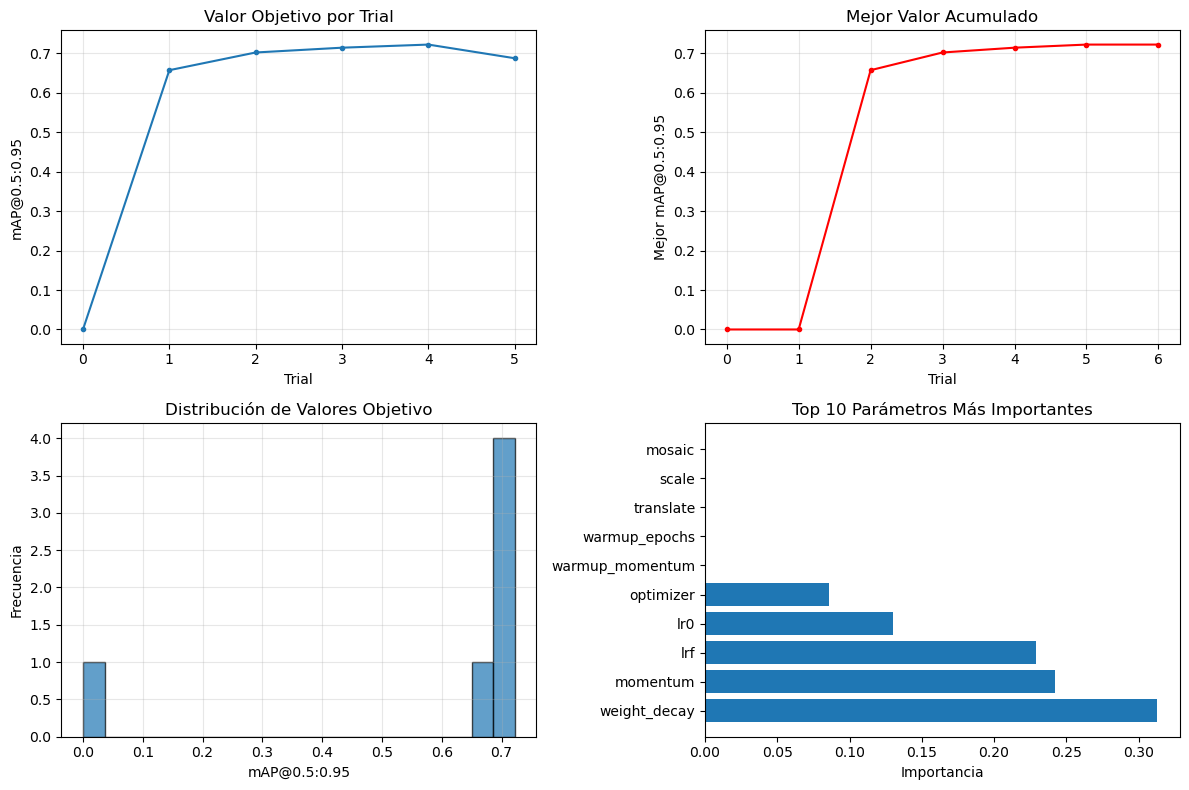

In [6]:
%matplotlib inline
optuna_utils.optuna_optimization_history(study, output_path=image_optuna_path)

In [7]:
with open(f"optuna/optuna_studies/{selected_model}_best_params.json", "r") as f:
    best_params = json.load(f)

print("Mejores hiperparámetros:")
for key, value in best_params.items():
    print(f"  {key}: {value}")

Mejores hiperparámetros:
  lr0: 0.00019010245319870352
  lrf: 0.001959497205867916
  momentum: 0.8549542764940538
  weight_decay: 0.0002858051065806936
  optimizer: SGD
  warmup_epochs: 5
  warmup_momentum: 0.75
  degrees: 45
  translate: 0.1
  scale: 0.06
  flipud: 0.5
  fliplr: 0.5
  mosaic: 0
  close_mosaic: 0


### **K-Fold Cross Validation**

Se concatena train y val para tener un dataset mayor para k-fold 373 imagenes en 4 folds.

In [11]:
params = best_params
# params = getattr(config, name_best_params)
metrics_df = kfold_utils.train(model, params, model_output_kfold)


Entrenando fold_1 (1/4)
New https://pypi.org/project/ultralytics/8.3.186 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.169 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA TITAN Xp, 12190MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=0, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=kfold/fold_1/data.yaml, degrees=45, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=40, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=704, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.00019010245319870352, lrf=0.001959497205867916, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo/yolo_models/yolo12l.pt, momentum=0.8549542764940538, 

train: Scanning /home/aitor/tfm/04.Codigo/kfold/fold_1/train/labels.cache...

val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1714.8±140.6 MB/s, size: 90.0 KB)



val: Scanning /home/aitor/tfm/04.Codigo/kfold/fold_1/val/labels.cache... 94 


Plotting labels to runs/detect/final_model_yolov12l_kfold/fold_1/labels.jpg... 
optimizer: SGD(lr=0.00019010245319870352, momentum=0.8549542764940538) with parameter groups 205 weight(decay=0.0), 214 weight(decay=0.0002858051065806936), 211 bias(decay=0.0)
Image sizes 704 train, 704 val
Using 0 dataloader workers
Logging results to runs/detect/final_model_yolov12l_kfold/fold_1
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/40      11.4G     0.7604     0.5543     0.8221         45        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         94       1100      0.842       0.85      0.896      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/40      11.5G     0.7541     0.5556     0.8185         70        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         94       1100      0.836      0.856      0.897      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/40      11.3G     0.7363     0.5451     0.8172         59        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         94       1100      0.837      0.856      0.896       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/40      11.5G     0.7501     0.5572     0.8151        105        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         94       1100      0.835      0.861      0.896      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/40      11.3G     0.7477     0.5556     0.8177        101        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         94       1100      0.836       0.86      0.896      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/40      11.3G     0.7671     0.5547     0.8198         68        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         94       1100      0.824      0.864      0.897      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/40      11.5G     0.7422     0.5564     0.8173         61        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         94       1100      0.825      0.865      0.897      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/40      11.3G      0.751     0.5471     0.8196         70        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         94       1100      0.829      0.865      0.897       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/40      11.3G     0.7486     0.5508      0.818         80        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         94       1100      0.832      0.858      0.896      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/40      11.3G     0.7367     0.5525      0.819        111        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         94       1100      0.833      0.857      0.897       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/40      11.3G     0.7495     0.5552     0.8189         83        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         94       1100      0.831      0.861      0.897        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/40      11.3G     0.7418     0.5402      0.816         93        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         94       1100       0.84      0.855      0.896      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/40      11.3G     0.7504      0.564     0.8243         80        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         94       1100      0.839      0.856      0.897      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/40      11.3G     0.7466      0.548     0.8192        116        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         94       1100      0.833      0.863      0.898      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/40      11.5G     0.7373     0.5488     0.8171         53        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         94       1100      0.837      0.858      0.898      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/40      11.3G     0.7433     0.5565     0.8188         28        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         94       1100      0.838      0.861      0.898      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/40      11.3G      0.751     0.5548     0.8223        130        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         94       1100      0.835      0.863      0.898      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/40      11.3G     0.7253     0.5543     0.8129         92        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         94       1100       0.84      0.854      0.897      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/40      11.3G      0.751     0.5473     0.8241         68        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         94       1100      0.841      0.854      0.897      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/40      11.3G     0.7663     0.5748     0.8261        128        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         94       1100      0.836      0.863      0.897      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/40      11.3G     0.7364     0.5521     0.8159         67        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         94       1100      0.837      0.861      0.897      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/40      11.3G     0.7498     0.5528     0.8204        124        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         94       1100      0.839      0.857      0.897      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/40      11.5G      0.741     0.5421     0.8186         62        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         94       1100       0.84      0.852      0.898        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/40      11.3G     0.7517     0.5567     0.8193         36        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         94       1100      0.835      0.862      0.897      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/40      11.3G      0.728      0.542     0.8135         46        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         94       1100       0.84      0.857      0.897      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/40      11.3G      0.738     0.5495     0.8185         96        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         94       1100       0.84      0.857      0.897      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/40      11.3G     0.7614     0.5501      0.818         77        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         94       1100      0.838      0.856      0.897      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/40      11.3G     0.7356      0.542     0.8141         49        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         94       1100      0.839       0.86      0.898      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/40      11.3G     0.7314     0.5472     0.8189         81        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         94       1100      0.836      0.862      0.898      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/40      11.3G     0.7339     0.5494     0.8077         47        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         94       1100      0.836      0.861      0.897      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/40      11.5G     0.7436     0.5493     0.8167         46        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         94       1100      0.839       0.86      0.898      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/40      11.3G     0.7411     0.5389     0.8171        119        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         94       1100      0.837       0.86      0.898      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/40      11.3G     0.7412     0.5461     0.8193        178        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         94       1100      0.837      0.859      0.898      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/40      11.3G     0.7676     0.5501     0.8172         48        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         94       1100      0.835      0.862      0.898      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/40      11.4G     0.7454      0.555     0.8194         58        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         94       1100      0.836      0.862      0.897      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/40      11.3G     0.7252     0.5411     0.8106         85        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         94       1100      0.834      0.862      0.897      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/40      11.3G     0.7405       0.54     0.8146         89        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         94       1100      0.837      0.862      0.897      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/40      11.3G     0.7556     0.5569     0.8165         42        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         94       1100      0.834       0.86      0.898      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/40      11.5G     0.7535     0.5428     0.8183        105        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         94       1100      0.833      0.861      0.898      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/40      11.4G     0.7277     0.5398     0.8133         81        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         94       1100      0.837      0.859      0.897      0.695



40 epochs completed in 0.565 hours.
Optimizer stripped from runs/detect/final_model_yolov12l_kfold/fold_1/weights/last.pt, 53.5MB
Optimizer stripped from runs/detect/final_model_yolov12l_kfold/fold_1/weights/best.pt, 53.5MB

Validating runs/detect/final_model_yolov12l_kfold/fold_1/weights/best.pt...
Ultralytics 8.3.169 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA TITAN Xp, 12190MiB)
YOLOv12l summary (fused): 283 layers, 26,339,843 parameters, 0 gradients, 88.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP5


                   all         94       1100       0.84      0.855      0.896      0.705
Speed: 0.2ms preprocess, 34.0ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/final_model_yolov12l_kfold/fold_1

Entrenando fold_2 (2/4)
New https://pypi.org/project/ultralytics/8.3.186 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.169 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA TITAN Xp, 12190MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=0, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=kfold/fold_2/data.yaml, degrees=45, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=40, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz

train: Scanning /home/aitor/tfm/04.Codigo/kfold/fold_2/train/labels.cache...

val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2154.8±516.8 MB/s, size: 98.9 KB)



val: Scanning /home/aitor/tfm/04.Codigo/kfold/fold_2/val/labels.cache... 93 

Plotting labels to runs/detect/final_model_yolov12l_kfold/fold_2/labels.jpg... 


optimizer: SGD(lr=0.00019010245319870352, momentum=0.8549542764940538) with parameter groups 205 weight(decay=0.0), 214 weight(decay=0.0002858051065806936), 211 bias(decay=0.0)
Image sizes 704 train, 704 val
Using 0 dataloader workers
Logging results to runs/detect/final_model_yolov12l_kfold/fold_2
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/40      11.2G      0.749      0.564      0.813        117        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1358      0.839      0.876      0.916      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/40      11.5G     0.7585     0.5668     0.8183         66        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1358      0.836      0.884      0.917      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/40      11.3G      0.753     0.5521     0.8199        131        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1358      0.837      0.886      0.918      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/40      11.6G      0.751     0.5591     0.8184        144        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1358      0.835       0.89      0.918      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/40      11.3G     0.7332     0.5506     0.8126         77        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1358      0.835      0.887      0.917      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/40      11.3G     0.7556     0.5582     0.8189         70        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1358       0.83       0.89      0.917      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/40      11.5G     0.7337     0.5505     0.8147        111        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1358      0.835      0.888      0.918      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/40      11.3G     0.7406     0.5539     0.8139         90        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1358      0.835      0.893      0.917      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/40      11.3G     0.7409     0.5507     0.8175         58        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1358      0.833      0.893      0.917      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/40      11.3G     0.7468     0.5514     0.8176         60        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1358      0.833      0.894      0.917      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/40      11.3G     0.7512     0.5448      0.813         61        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1358      0.835      0.892      0.918      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/40      11.4G     0.7769      0.567     0.8233        109        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1358      0.839      0.884      0.917      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/40      11.3G     0.7335     0.5468     0.8161         81        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1358      0.836      0.884      0.918      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/40      11.3G      0.745     0.5492     0.8166         79        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1358      0.838      0.883      0.916      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/40      11.5G     0.7473     0.5485     0.8188         97        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1358      0.837      0.881      0.916      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/40      11.3G     0.7499     0.5572     0.8152        160        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1358      0.834      0.885      0.917      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/40      11.3G     0.7644     0.5759     0.8256        189        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1358      0.834      0.883      0.916      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/40      11.3G     0.7549     0.5652     0.8187        139        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1358      0.834      0.887      0.916       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/40      11.3G     0.7472     0.5594     0.8184        157        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1358      0.838      0.883      0.916       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/40      11.3G     0.7397     0.5424     0.8122         62        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1358      0.839       0.88      0.917      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/40      11.3G     0.7388     0.5501     0.8192         91        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1358      0.838      0.886      0.917      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/40      11.3G     0.7537     0.5619     0.8158         47        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1358      0.834      0.884      0.917      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/40      11.5G     0.7462     0.5543     0.8129         71        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1358      0.835      0.883      0.916      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/40      11.3G     0.7352     0.5478     0.8141         65        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1358      0.838      0.884      0.917      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/40      11.3G     0.7389      0.558     0.8203        112        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1358      0.845      0.876      0.916      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/40      11.3G     0.7418     0.5495     0.8193         52        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1358      0.842      0.878      0.917      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/40      11.3G     0.7422     0.5606     0.8157        145        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1358      0.832      0.887      0.917      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/40      11.3G     0.7431      0.542     0.8175        136        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1358      0.835      0.887      0.917      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/40      11.3G     0.7404     0.5456     0.8172         74        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1358      0.839      0.884      0.917      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/40      11.3G     0.7352     0.5723     0.8069         66        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1358      0.838      0.885      0.917       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/40      11.5G     0.7322     0.5473     0.8132         56        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1358      0.833      0.885      0.917       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/40      11.3G     0.7405      0.554     0.8194         88        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1358      0.838      0.884      0.917       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/40      11.3G     0.7316     0.5517     0.8129         91        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1358      0.841      0.882      0.917      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/40      11.3G      0.753       0.57     0.8243         58        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1358      0.839      0.881      0.917      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/40      11.3G     0.7433      0.552     0.8159        121        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1358      0.831      0.891      0.917      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/40      11.3G     0.7306     0.5314     0.8136         64        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1358      0.842       0.88      0.917      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/40      11.3G      0.739     0.5534     0.8173        111        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1358       0.84       0.88      0.917      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/40      11.3G     0.7253     0.5371      0.813         89        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1358      0.843      0.879      0.917      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/40      11.5G     0.7766     0.5707     0.8284         85        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1358      0.837      0.887      0.917       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/40      11.3G     0.7445     0.5489     0.8179         83        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1358      0.838      0.887      0.918      0.721



40 epochs completed in 0.567 hours.
Optimizer stripped from runs/detect/final_model_yolov12l_kfold/fold_2/weights/last.pt, 53.5MB
Optimizer stripped from runs/detect/final_model_yolov12l_kfold/fold_2/weights/best.pt, 53.5MB

Validating runs/detect/final_model_yolov12l_kfold/fold_2/weights/best.pt...
Ultralytics 8.3.169 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA TITAN Xp, 12190MiB)
YOLOv12l summary (fused): 283 layers, 26,339,843 parameters, 0 gradients, 88.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP5


                   all         93       1358      0.837      0.883      0.916      0.725
Speed: 0.2ms preprocess, 34.1ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/final_model_yolov12l_kfold/fold_2

Entrenando fold_3 (3/4)
New https://pypi.org/project/ultralytics/8.3.186 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.169 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA TITAN Xp, 12190MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=0, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=kfold/fold_3/data.yaml, degrees=45, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=40, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz

train: Scanning /home/aitor/tfm/04.Codigo/kfold/fold_3/train/labels.cache...

val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1926.9±100.6 MB/s, size: 96.2 KB)



val: Scanning /home/aitor/tfm/04.Codigo/kfold/fold_3/val/labels.cache... 93 

Plotting labels to runs/detect/final_model_yolov12l_kfold/fold_3/labels.jpg... 


optimizer: SGD(lr=0.00019010245319870352, momentum=0.8549542764940538) with parameter groups 205 weight(decay=0.0), 214 weight(decay=0.0002858051065806936), 211 bias(decay=0.0)
Image sizes 704 train, 704 val
Using 0 dataloader workers
Logging results to runs/detect/final_model_yolov12l_kfold/fold_3
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/40      11.2G     0.7689     0.5446     0.8244         60        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1207      0.836      0.866      0.914      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/40      11.5G     0.7464     0.5497     0.8179         69        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1207      0.845      0.855      0.914      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/40      11.3G     0.7489     0.5589     0.8127        121        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1207      0.841      0.862      0.914      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/40      11.5G      0.752     0.5515     0.8158        139        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1207      0.837      0.862      0.913      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/40      11.3G     0.7436     0.5497     0.8227        110        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1207      0.838      0.864      0.915      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/40      11.4G     0.7549     0.5461     0.8175         63        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1207      0.837      0.862      0.914      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/40      11.5G     0.7576     0.5493     0.8157        186        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1207      0.838      0.861      0.913      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/40      11.3G      0.761     0.5467      0.819        162        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1207      0.842      0.859      0.914      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/40      11.3G     0.7575     0.5464     0.8204         29        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1207      0.837      0.862      0.914      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/40      11.3G     0.7549       0.55     0.8185        169        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1207      0.828      0.872      0.914      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/40      11.3G     0.7425     0.5524     0.8129         96        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1207      0.845      0.855      0.914      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/40      11.3G      0.751     0.5545     0.8178         91        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1207      0.843      0.858      0.914      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/40      11.3G     0.7387     0.5472     0.8179         58        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1207      0.832      0.872      0.914       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/40      11.3G     0.7353     0.5483     0.8157         79        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1207      0.843      0.856      0.915      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/40      11.3G     0.7519     0.5535     0.8156        128        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1207      0.845      0.857      0.914      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/40      11.3G     0.7403     0.5386      0.815         50        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1207      0.831       0.87      0.914      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/40      11.3G     0.7403     0.5447     0.8157         67        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1207      0.832       0.87      0.914      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/40      11.3G     0.7422     0.5456      0.819         52        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1207      0.844      0.857      0.915      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/40      11.3G     0.7319     0.5357     0.8179         91        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1207      0.843      0.859      0.915      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/40      11.3G     0.7413     0.5344     0.8162         59        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1207      0.843      0.857      0.914       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/40      11.5G     0.7396     0.5481     0.8141         53        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1207      0.846      0.856      0.914      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/40      11.3G     0.7509     0.5449     0.8182         77        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1207      0.848      0.855      0.914      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/40      11.3G     0.7272     0.5381     0.8142        113        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1207      0.846      0.857      0.914      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/40      11.3G     0.7442      0.537     0.8185         77        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1207       0.84      0.858      0.914      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/40      11.3G     0.7256     0.5395     0.8099        154        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1207      0.843      0.857      0.914      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/40      11.3G     0.7421     0.5348     0.8137         48        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1207      0.837      0.867      0.915      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/40      11.3G      0.738     0.5404     0.8234        130        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1207      0.839       0.86      0.915      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/40      11.3G     0.7364     0.5357     0.8127         98        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1207      0.844      0.858      0.914      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/40      11.5G     0.7405     0.5438     0.8142         51        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1207      0.839      0.861      0.915      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/40      11.3G     0.7386     0.5397     0.8149         83        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1207       0.84      0.862      0.915      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/40      11.3G     0.7373     0.5419     0.8197         51        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1207      0.841       0.86      0.914      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/40      11.3G     0.7428     0.5387     0.8219         97        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1207      0.841      0.861      0.914      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/40      11.3G     0.7489      0.541     0.8225        130        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1207      0.841      0.861      0.914       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/40      11.3G     0.7263     0.5394     0.8159        142        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1207       0.84      0.861      0.914      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/40      11.3G      0.754     0.5343     0.8179        113        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1207      0.841      0.861      0.914      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/40      11.3G     0.7325     0.5345     0.8181         77        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1207      0.842      0.859      0.914      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/40      11.5G      0.732     0.5463     0.8118         99        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1207      0.843       0.86      0.914      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/40      11.3G     0.7489      0.547     0.8212         85        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1207       0.84      0.862      0.915      0.724



40 epochs completed in 0.569 hours.
Optimizer stripped from runs/detect/final_model_yolov12l_kfold/fold_3/weights/last.pt, 53.5MB
Optimizer stripped from runs/detect/final_model_yolov12l_kfold/fold_3/weights/best.pt, 53.5MB

Validating runs/detect/final_model_yolov12l_kfold/fold_3/weights/best.pt...
Ultralytics 8.3.169 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA TITAN Xp, 12190MiB)
YOLOv12l summary (fused): 283 layers, 26,339,843 parameters, 0 gradients, 88.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP5


                   all         93       1207      0.843      0.858      0.914      0.728
Speed: 0.2ms preprocess, 34.5ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/final_model_yolov12l_kfold/fold_3

Entrenando fold_4 (4/4)
New https://pypi.org/project/ultralytics/8.3.186 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.169 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA TITAN Xp, 12190MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=0, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=kfold/fold_4/data.yaml, degrees=45, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=40, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz

train: Scanning /home/aitor/tfm/04.Codigo/kfold/fold_4/train/labels.cache...

val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1877.6±393.0 MB/s, size: 85.3 KB)



val: Scanning /home/aitor/tfm/04.Codigo/kfold/fold_4/val/labels.cache... 93 

Plotting labels to runs/detect/final_model_yolov12l_kfold/fold_4/labels.jpg... 


optimizer: SGD(lr=0.00019010245319870352, momentum=0.8549542764940538) with parameter groups 205 weight(decay=0.0), 214 weight(decay=0.0002858051065806936), 211 bias(decay=0.0)
Image sizes 704 train, 704 val
Using 0 dataloader workers
Logging results to runs/detect/final_model_yolov12l_kfold/fold_4
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/40      11.7G     0.7214     0.5519     0.8104        120        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1147      0.844      0.875      0.923      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/40      11.5G     0.7549     0.5478     0.8205         56        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1147      0.851      0.867      0.923      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/40      11.3G      0.755     0.5589     0.8202        238        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1147      0.845      0.875      0.923      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/40      11.5G     0.7338     0.5376      0.817         91        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1147      0.832      0.888      0.923      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/40      11.3G     0.7266     0.5493     0.8148        108        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1147      0.845      0.873      0.923      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/40      11.3G     0.7545     0.5505      0.817         37        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1147      0.846      0.874      0.923      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/40      11.5G     0.7412     0.5507     0.8164         28        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1147      0.839      0.881      0.923      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/40      11.3G     0.7379     0.5527     0.8144        156        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1147      0.843      0.876      0.923      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/40      11.3G     0.7271     0.5441      0.815        115        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1147      0.838      0.875      0.922      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/40      11.3G     0.7406     0.5566     0.8138         40        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1147       0.84      0.877      0.923      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/40      11.3G     0.7636     0.5604     0.8194        105        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1147      0.841      0.883      0.923      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/40      11.3G     0.7534     0.5604     0.8209         67        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1147      0.835      0.885      0.923      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/40      11.3G     0.7233     0.5471     0.8189         61        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1147       0.84      0.879      0.923      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/40      11.3G     0.7561     0.5579     0.8154         77        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1147      0.841      0.881      0.923      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/40      11.5G     0.7275     0.5493     0.8133        177        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1147      0.844      0.879      0.923      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/40      11.3G     0.7492      0.551      0.821         68        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1147      0.842      0.877      0.922      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/40      11.3G     0.7479     0.5516     0.8205        151        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1147      0.837      0.881      0.923      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/40      11.3G      0.728     0.5541      0.816        142        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1147      0.843      0.874      0.922      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/40      11.3G     0.7582     0.5449     0.8201        176        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1147      0.845      0.877      0.922      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/40      11.3G     0.7118     0.5307     0.8132        118        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1147      0.846      0.875      0.922      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/40      11.3G     0.7143     0.5378     0.8126        115        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1147      0.842      0.877      0.922      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/40      11.3G     0.7179     0.5318     0.8158         87        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1147       0.84      0.877      0.922      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/40      11.5G     0.7361     0.5471     0.8144         78        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1147      0.836      0.885      0.922      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/40      11.3G     0.7452     0.5523     0.8197         72        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1147      0.841      0.878      0.923      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/40      11.3G     0.7306     0.5418     0.8181        130        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1147       0.84      0.876      0.922      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/40      11.3G     0.7296     0.5464     0.8184         63        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1147      0.842      0.874      0.923      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/40      11.3G     0.7205     0.5398     0.8137        125        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1147       0.84      0.876      0.923      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/40      11.3G      0.729     0.5391     0.8116        113        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1147      0.842      0.875      0.923      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/40      11.3G     0.7312     0.5413     0.8148         65        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1147      0.839      0.878      0.923      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/40      11.3G     0.7407      0.548     0.8211        125        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1147      0.837      0.881      0.922      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/40      11.5G     0.7309     0.5525     0.8129         96        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1147      0.837      0.881      0.923      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/40      11.3G     0.7184     0.5372     0.8105         91        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1147      0.837       0.88      0.923      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/40      11.3G     0.7409     0.5538     0.8167        123        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1147      0.836      0.882      0.923      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/40      11.3G     0.7242     0.5311     0.8136         27        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1147      0.836      0.882      0.923      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/40      11.3G     0.7219     0.5451     0.8132         60        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1147      0.835      0.884      0.923      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/40      11.3G     0.7248     0.5454     0.8119         93        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1147      0.835      0.884      0.923      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/40      11.3G      0.725     0.5366     0.8131        119        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1147       0.84      0.878      0.923      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/40      11.3G     0.7253     0.5418     0.8137        107        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1147      0.837      0.884      0.923      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/40      11.5G     0.7438     0.5389     0.8141        110        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1147      0.838       0.88      0.923      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/40      11.3G     0.7239     0.5565       0.82         76        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         93       1147       0.84      0.878      0.923      0.733



40 epochs completed in 0.570 hours.
Optimizer stripped from runs/detect/final_model_yolov12l_kfold/fold_4/weights/last.pt, 53.5MB
Optimizer stripped from runs/detect/final_model_yolov12l_kfold/fold_4/weights/best.pt, 53.5MB

Validating runs/detect/final_model_yolov12l_kfold/fold_4/weights/best.pt...
Ultralytics 8.3.169 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA TITAN Xp, 12190MiB)
YOLOv12l summary (fused): 283 layers, 26,339,843 parameters, 0 gradients, 88.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP5


                   all         93       1147      0.842      0.874      0.922      0.736
Speed: 0.2ms preprocess, 33.7ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/final_model_yolov12l_kfold/fold_4


In [12]:
kfold_utils.save_results(metrics_df, model_output_kfold)


Resultados por fold:
   fold  mAP50-95    mAP50  precision   recall
0     1   0.70587  0.89631    0.83983  0.85455
1     2   0.72552  0.91620    0.83838  0.88292
2     3   0.72768  0.91399    0.84307  0.85833
3     4   0.73609  0.92258    0.84188  0.87358

Promedio de métricas:
mAP50-95     0.723790
mAP50        0.912270
precision    0.840790
recall       0.867345
dtype: float64

Desviación estándar de métricas:
mAP50-95     0.012787
mAP50        0.011246
precision    0.002091
recall       0.013247
dtype: float64

Directorios temporales eliminados.


Gráfico guardado en: runs/detect/final_model_yolov12l_kfold/kfold_metrics.png


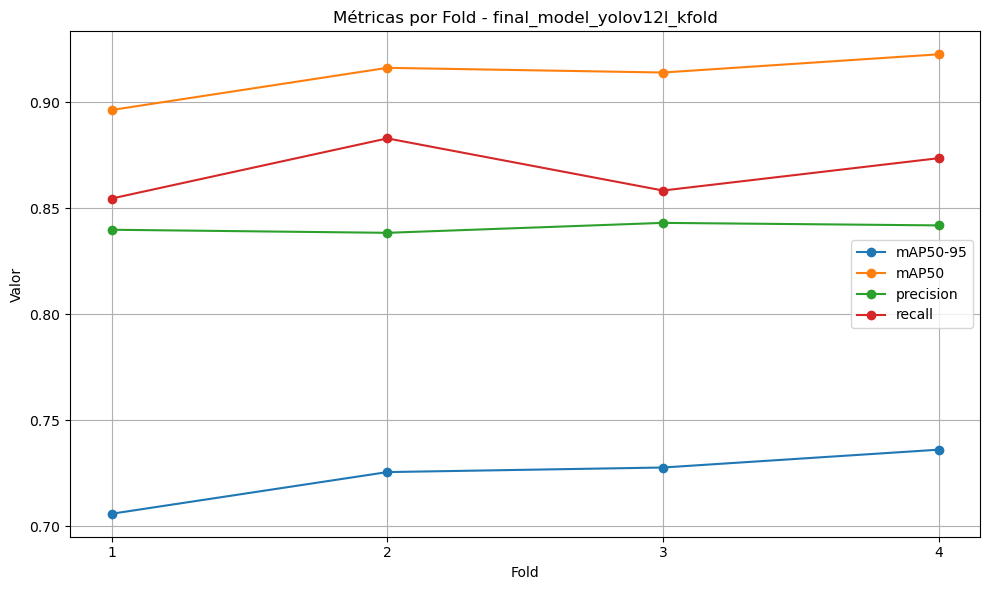

In [13]:
%matplotlib inline
kfold_utils.plot_kfold_metrics(metrics_df, model_output_kfold)

### **Train**

In [8]:
# params = getattr(config, name_best_params)
params = best_params

model.train(
    data="cells.yaml",
    epochs=config.EPOCH_TRAIN,   
    imgsz=config.IMGSZ,          
    batch=config.BATCH,           
    name=model_output,
    save=True,  
    seed=config.SEED, 
    workers=0,
    **params
)

New https://pypi.org/project/ultralytics/8.3.186 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.169 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA TITAN Xp, 12190MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=0, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=cells.yaml, degrees=45, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=40, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=704, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.00019010245319870352, lrf=0.001959497205867916, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo/yolo_models/yolo12l.pt, momentum=0.8549542764940538, mosaic=0, multi_scale=False, name=fin

train: Scanning /home/aitor/tfm/03.Datasets/YOLO_Datasets/split/train/labels

val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1819.7±281.6 MB/s, size: 89.7 KB)



val: Scanning /home/aitor/tfm/03.Datasets/YOLO_Datasets/split/val/labels.cac

Plotting labels to runs/detect/final_model_yolov12l/labels.jpg... 


optimizer: SGD(lr=0.00019010245319870352, momentum=0.8549542764940538) with parameter groups 205 weight(decay=0.0), 214 weight(decay=0.0002858051065806936), 211 bias(decay=0.0)
Image sizes 704 train, 704 val
Using 0 dataloader workers
Logging results to runs/detect/final_model_yolov12l
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/40      11.5G     0.7663     0.5456     0.8147         50        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.793      0.865      0.884      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/40      11.6G     0.7729     0.5739     0.8185          4        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955       0.79      0.867      0.884      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/40      11.4G     0.7615     0.5454     0.8212         28        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.794      0.867      0.885      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/40      11.5G     0.7544     0.5456     0.8168         25        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.793      0.871      0.885      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/40      11.4G     0.7586     0.6947     0.8033          0        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.792      0.867      0.885      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/40      11.4G     0.7356     0.5414     0.8167          8        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.799      0.863      0.885      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/40      11.5G      0.748     0.5655     0.8146          8        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.801      0.861      0.885      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/40      11.4G     0.7434     0.5385     0.8119          5        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.797      0.865      0.883       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/40      11.4G     0.7258     0.5456     0.8099          4        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.795      0.867      0.885      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/40      11.4G     0.7475     0.5433     0.8175         31        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.802      0.862      0.886      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/40      11.4G      0.739     0.5419     0.8153         42        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.803      0.858      0.884      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/40      11.4G     0.7503     0.5342     0.8197         22        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.805      0.857      0.886      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/40      11.4G     0.7013     0.5355     0.8131         13        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.793      0.863      0.885      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/40      11.4G     0.7213     0.5245     0.8125         48        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.801      0.858      0.886      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/40      11.4G     0.7207     0.5426     0.8112          2        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.801       0.86      0.886      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/40      11.4G      0.718      0.534     0.8151          2        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.802       0.86      0.886      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/40      11.4G     0.7255     0.5377     0.8105         22        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.792      0.867      0.885       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/40      11.4G      0.725     0.5417     0.8136          7        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.793      0.867      0.885       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/40      11.4G     0.7195     0.5315     0.8116          7        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.794      0.867      0.885      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/40      11.4G     0.7168     0.5291     0.8166         28        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.799      0.859      0.886      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/40      11.4G     0.7094     0.5204     0.8105         50        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.802      0.859      0.886      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/40      11.4G     0.7031     0.5237      0.814         15        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.798      0.863      0.887      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/40      11.4G     0.7096       0.54     0.8104          3        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.797      0.868      0.887      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/40      11.5G      0.737      0.544     0.8146         16        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.791       0.87      0.886      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/40      11.4G     0.7457     0.5343     0.8179         18        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.796      0.869      0.886      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/40      11.4G     0.7567     0.5467     0.8186         25        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.794      0.863      0.886      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/40      11.4G     0.7475     0.5544     0.8181         48        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.799      0.867      0.886      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/40      11.4G      0.735      0.542     0.8136         20        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.792      0.868      0.887      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/40      11.5G     0.7552     0.5364     0.8183         35        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.792      0.873      0.886      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/40      11.4G      0.761     0.5613     0.8166          4        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.792      0.871      0.887      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/40      11.4G     0.7476     0.5459     0.8164         23        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.793       0.87      0.887      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/40      11.4G     0.7512     0.5489     0.8168          8        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.797      0.869      0.887      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/40      11.4G     0.7414     0.5532     0.8149          5        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.794      0.867      0.887      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/40      11.4G     0.7597     0.5451     0.8179         22        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.798      0.868      0.887        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/40      11.4G     0.7599     0.5512     0.8182         17        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.796      0.867      0.886        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/40      11.4G     0.7573     0.5379      0.816         32        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.792      0.867      0.885      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/40      11.4G     0.7472     0.5397     0.8207         12        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.795      0.865      0.885      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/40      11.4G     0.7616     0.5522     0.8184          4        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.788      0.867      0.885      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/40      11.4G     0.7351      0.547     0.8162         20        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955      0.791      0.866      0.886        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/40      11.4G      0.727     0.5373     0.8137         28        70
                 Class     Images  Instances      Box(P          R      mAP5

                   all         75        955       0.79      0.867      0.887        0.7



40 epochs completed in 0.597 hours.
Optimizer stripped from runs/detect/final_model_yolov12l/weights/last.pt, 53.5MB
Optimizer stripped from runs/detect/final_model_yolov12l/weights/best.pt, 53.5MB

Validating runs/detect/final_model_yolov12l/weights/best.pt...
Ultralytics 8.3.169 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA TITAN Xp, 12190MiB)
YOLOv12l summary (fused): 283 layers, 26,339,843 parameters, 0 gradients, 88.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP5


                   all         75        955      0.789      0.868      0.885      0.702
Speed: 0.2ms preprocess, 35.2ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/final_model_yolov12l


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fdafc759ed0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

### **Train Plots**

In [ ]:
plots_dir = 'yolo/yolo_plots'
dfs = plot_utils.load_experiment_results(config.results_csv_paths)

plot_utils.create_and_save_individual_plot(dfs, plots_dir,'map50-95', 'metrics/mAP50-95(B)', 'Training mAP@0.5:0.95', 'mAP@0.5:0.95')
plot_utils.create_and_save_individual_plot(dfs, plots_dir,'map50', 'metrics/mAP50(B)', 'Training mAP@0.5', 'mAP@0.5')
plot_utils.create_and_save_individual_plot(dfs, plots_dir,'precision', 'metrics/precision(B)', 'Val Precision', 'Precision')
plot_utils.create_and_save_individual_plot(dfs, plots_dir,'recall', 'metrics/recall(B)', 'Val Recall', 'Recall')
plot_utils.create_and_save_individual_plot(dfs, plots_dir,'box_loss', ['train/box_loss', 'val/box_loss'], 
                               'Training & Validation Box Loss', 'Box Loss', True, (0, 4))
plot_utils.create_and_save_individual_plot(dfs, plots_dir,'cls_loss', ['train/cls_loss', 'val/cls_loss'], 
                               'Training & Validation Classification Loss', 'Cls Loss', True, (0, 4))

## **Evaluación**

In [ ]:
# tests = ["original_test"]
tests = ["test", "test2", "test3"]

results = evaluation.evaluate_models(tests=tests)

Ultralytics 8.3.169 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA TITAN Xp, 12190MiB)
YOLOv12l summary (fused): 283 layers, 26,339,843 parameters, 0 gradients, 88.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1765.8±702.6 MB/s, size: 92.1 KB)


val: Scanning /home/aitor/tfm/03.Datasets/YOLO_Datasets/test/labels.cache...
                 Class     Images  Instances      Box(P          R      mAP5


                   all         94       1412      0.846      0.889      0.934      0.714
Speed: 0.2ms preprocess, 26.0ms inference, 0.0ms loss, 5.1ms postprocess per image
Results saved to runs/detect/eval_yolov12l_test2
Ultralytics 8.3.169 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA TITAN Xp, 12190MiB)
YOLOv12l summary (fused): 283 layers, 26,339,843 parameters, 0 gradients, 88.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2337.0±322.5 MB/s, size: 103.4 KB)


val: Scanning ../03.Datasets/YOLO_Datasets/test2/labels... 10 images, 0 back

val: New cache created: ../03.Datasets/YOLO_Datasets/test2/labels.cache



                 Class     Images  Instances      Box(P          R      mAP5


                   all         10        144      0.957      0.926      0.975      0.562
Speed: 0.2ms preprocess, 39.8ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/eval_yolov12l_test22
Ultralytics 8.3.169 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA TITAN Xp, 12190MiB)
YOLOv12l summary (fused): 283 layers, 26,339,843 parameters, 0 gradients, 88.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3437.5±786.4 MB/s, size: 248.0 KB)


val: Scanning ../03.Datasets/YOLO_Datasets/test3/labels... 59 images, 0 back

val: New cache created: ../03.Datasets/YOLO_Datasets/test3/labels.cache



                 Class     Images  Instances      Box(P          R      mAP5


                   all         59       1135      0.849      0.894      0.942      0.701
Speed: 0.3ms preprocess, 25.9ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/eval_yolov12l_test3


In [ ]:
# RESULTADOS CUANDO SE CARGARON LAS ANOTACIONES DE TEST ORIGINAL
df = pd.DataFrame(results)
display(df[df["Test"] == "original_test"])

In [4]:
df = pd.DataFrame(results)
display(df)

,Modelo,Test,Precisión,Recall,mAP@0.5,mAP@0.5:0.95,Time_s,Inferencia_ms
0,yolov12l,test,0.846,0.889,0.934,0.714,8.917,26.006
1,yolov12l,test2,0.957,0.926,0.975,0.562,3.538,39.849
2,yolov12l,test3,0.849,0.894,0.942,0.701,6.008,25.930
